# A Simple Illustration of a 2-Dimensional Groundwater Model
## By: Lejo Flores

This is an example of a 2-dimensional model of landscape evolution (i.e., the evolution of surface topography with time) in which the domain is square. Here we treat the process of hillslope sediment transport as being a diffusive process associated with soil creep. For a diffusive soil creep process, the rate of sediment transport increases in direct proportion to the slope of the landscape; higher slopes mean higher sediment transport. The soil is assumed to be heterogeneous, and isotropic (i.e., there is one value of diffusivity $D$ that is valid everywhere in the domain and in all directions). The purpose of this Jupyter notebook is to illustrate how solution of this 2-D diffusive process is mostly an extension of the previously reviewed 1D diffusion examples into a second dimension. 

Conceptually this model is pretty straightforward - in addition to gradients of elevation in the $x$ direction there is now the need to also compute elevation gradients in the $y$ direction. We will reduce this problem to a suite of discrete linear relationships and use linear algebra, matrix-vector multiplication to solve the system of equations. This requires us to represent, or "flatten," our 2D domain into a column vector. However, where this introduces complications in the numerics is in the "bookkeeping" of keeping track of where in our column vector the cells that were north and south of a central pixel now are after we "flatten" our domain. I illustrate how this works out using a "100s chart" from my daughter's 1st grade classroom, because that's the simplist way to figure out how this works in a general way. 

## A Review of the Maths

\begin{equation}
\frac{\partial z}{\partial t} = D\left(\frac{\partial^2z}{\partial x^2}+\frac{\partial^2z}{\partial y^2}\right) + U
\end{equation}

<img src="img/5pt_Stencil.png" style="width: 200px;"/>


In [1]:
import numpy as np
import matplotlib.pyplot as plt

hi = 100.0 # (m)
D = 2.5 # (m^2/yr)

ti = 0.0 # (yr)
tf = 15000.0 # (yr)
dt = 5 # (yr)

# Uplift rate (m/yr)
U = 0.005 # (m/yr)

# Plotting options
individual_plots = 0 # If 1, individual plot at every output interval, all stacked otherwise
OutputInterval = 3000.0 # (yr)

Nt = (tf - ti)/dt + 1

Noutput = (tf - ti)/OutputInterval + 1

xMax = yMax = 500.0
xMin = yMin = 0.0
Nx = Ny = 50

x = np.linspace(xMin,xMax,Nx)
y = np.linspace(yMin,yMax,Ny)

dx = x[1] - x[0]
dy = y[1] - y[0]

X, Y = np.meshgrid(x,y)

## Plot the X and Y grid meshes

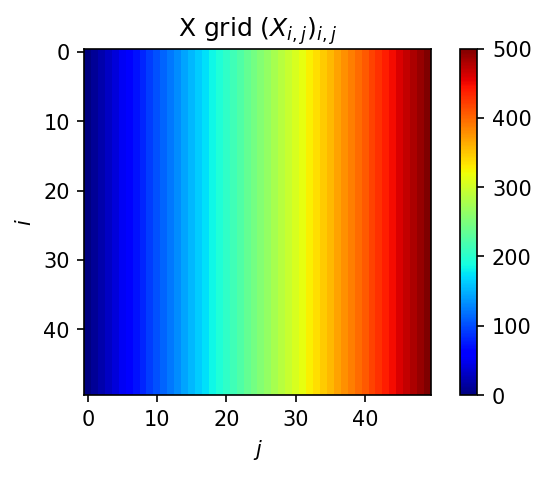

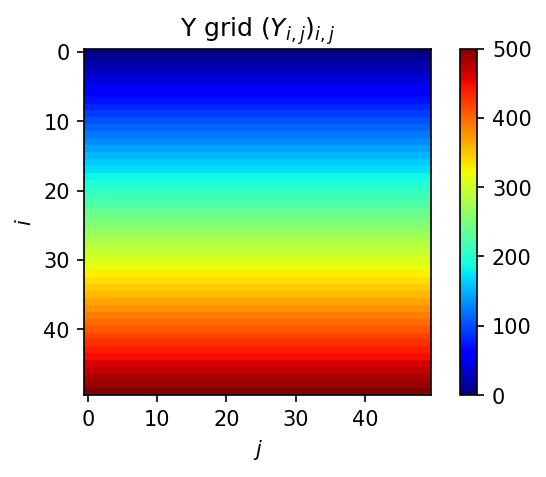

In [2]:
# Plot X grid
plt.figure(1,figsize=(5,3), dpi=150)
plt.title("X grid $(X_{i,j})_{i,j}$")
plt.xlabel(r"$j$")
plt.ylabel(r"$i$")
plt.imshow(X,cmap="jet")
plt.colorbar()
plt.show()

# Plot Y grid
plt.figure(2,figsize=(5,3), dpi=150)
plt.title("Y grid $(Y_{i,j})_{i,j}$")
plt.xlabel(r"$j$")
plt.ylabel(r"$i$")
plt.imshow(Y,cmap="jet")
plt.colorbar()
plt.show()


## Compute the stability variable 

In [3]:
alpha = D*dt/dx**2
print("alpha = ",alpha)
print("dt = ",dt)
print("dx = ",dx)
if alpha >= 0.5:
    raise Exception("Stability criteria error! Either decrease dt or increase dx!")

alpha =  0.12005000000000002
dt =  5
dx =  10.204081632653061


## Set up the solver matrix 


<img src="img/100sChart.png" style="width: 300px;"/>

<img src="img/100sChartStencilEx.png" style="width: 300px;"/>


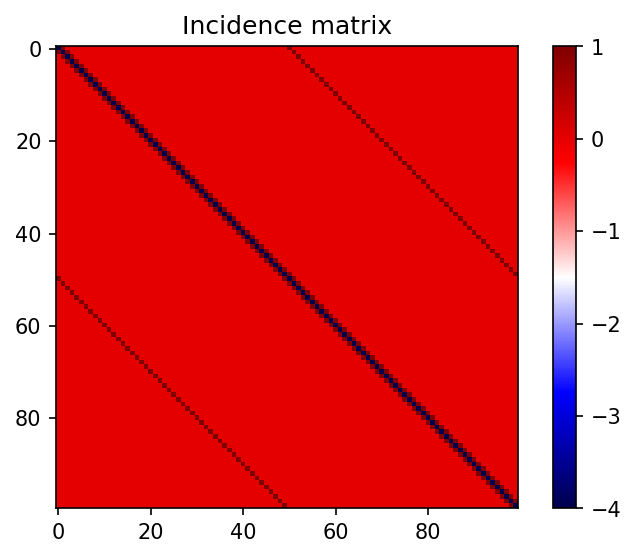

In [4]:
N = Nx*Ny

ind = np.linspace(0,N-1,N)
Ind = np.linspace(0,N-1,N).reshape((Ny,Nx))

Delta2 = np.matrix(np.diagflat(-4.0*np.ones((int(N),1)),k=0) + np.diagflat(np.ones((int(N-1),1)),k=1) \
    + np.diagflat(np.ones((int(N-1),1)),k=-1) + np.diagflat(np.ones((int(N-Nx),1)),k=int(Nx)) \
    + np.diagflat(np.ones((int(N-Ny),1)),k=-(int(Ny))))

plt.figure(3,figsize=(6,4), dpi=150)
plt.title("Incidence matrix")
plt.imshow(Delta2[0:(2*int(Ny)),0:(2*int(Nx))],cmap="seismic")
plt.colorbar()
plt.show()

## Setting up the boundary conditions

In [5]:
NBound = np.array(Ind[0,:])
SBound = np.array(Ind[-1,:])
WBound = np.array(Ind[:,0])
EBound = np.array(Ind[:,-1])

# Now compute the boundary conditions on the sides of the domain as the temporal evolution of a !D
# profile in response to a lowering of head on 1-side of the domain

Delta2_1D = np.matrix(np.diagflat(-2.0*np.ones((int(Nx),1)),k=0) + np.diagflat(np.ones((int(Nx-1),1)),k=1) \
    + np.diagflat(np.ones((int(Nx-1),1)),k=-1))

h0_1D = hi*np.ones(shape=(int(Nx),1))

H_1D = np.matrix(np.zeros(shape=(int(Nx),int(Nt))))

H_1D[:,0] = np.matrix(h0_1D)

for i in range(1,int(Nt)):
    hinit_1D = H_1D[:,i-1] 
        
    hnext_1D = hinit_1D + alpha*Delta2_1D*hinit_1D + U*dt
    hnext_1D[0] = hi
    hnext_1D[-1] = hi

    H_1D[:,i] = hnext_1D[:,0]

## Running the model

In [ ]:
import matplotlib as mpl

h0 = hi*np.ones(shape=(int(N),1)) + 0.1*np.random.randn(N,1)
hnext = np.matrix(h0)

figcounter = 1

for i in range(1,int(Nt)):
    hinit = hnext + U*dt
    
    hnext = hinit + alpha*Delta2*hinit 

    hnext[NBound.astype(int)] = H_1D[:,i]
    hnext[EBound.astype(int)] = H_1D[:,i] 
    hnext[SBound.astype(int)] = H_1D[:,i]
    hnext[WBound.astype(int)] = H_1D[:,i]
    
    if(i==1) or ((i*dt) % OutputInterval == 0):
        H = np.reshape(hnext,(Ny,Nx))

        if(individual_plots==1):
            fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(14,10), dpi=150)
            ax.set_title("Elevation $h_{i,j}$ at t = %s"%(i*dt), fontsize=18)
        else:
            if(figcounter==1):
                fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(14,10), dpi=150)
            ax.set_title('Elevation [m]', fontsize=18)
        ax.set_xlabel('$x$', fontsize=18)
        ax.set_ylabel('$y$', fontsize=18)
        ax.set_zlabel('Elevation [m]', fontsize=18)
        ax.set_xticks(np.arange(xMin,xMax+1.0,(xMax-xMin)/5))
        ax.set_yticks(np.arange(yMin,yMax+1.0,(yMax-yMin)/5))
        mpl.rcParams['xtick.labelsize'] = 16
        mpl.rcParams['ytick.labelsize'] = 16
        ax.plot_surface(X,Y,H,cmap='YlGnBu_r',linewidth=0.2,edgecolors='k')
        ax.set_zlim(hi, hi+U*dt*Nt)
        ax.view_init(elev=20.0)
        figcounter = figcounter + 1

plt.show()

### 